In [1]:
from lenskit.metrics import dataGenerator
from lenskit import batch, topn, util, topnFair
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, funksvd, basic, item_knn as knn
from lenskit import topn, topnFair

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
import math

In [4]:
ratings = pd.read_csv('/Users/denisehansen/Desktop/ITU/Thesis/Fair-Recommendations/ml-latest-small/ratings.csv', sep=',',
                      names=['user', 'item', 'rating', 'timestamp'], header=0)

items = pd.read_csv('/Users/denisehansen/Desktop/ITU/Thesis/Fair-Recommendations/ml-latest-small/movies.csv', sep=',',
                      names=['item','title','genres'], header=0)

#ratings = pd.read_csv('/Users/josse/Git-kode projects/Speciale/Fair-Recommendations/ml-latest-small/ratings.1.csv', sep=',',
#                      names=['user', 'item', 'rating', 'timestamp'], header=0)

#items = pd.read_csv('/Users/josse/Git-kode projects/Speciale/Fair-Recommendations/ml-latest-small/movies.csv', sep=',',
#                      names=['item','title','genres'], header=0)

#C:\Users\josse\Git-kode projects\Speciale\Fair-Recommendations\ml-latest-small\ratings.csv

In [5]:
items.head()

,item,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
items['year'] = items.title.str.extract("\((\d{4})\)", expand=True)
items.year = pd.to_datetime(items.year, format='%Y')
items.year = items.year.dt.year
items.title = items.title.str[:-7]

In [7]:
items.head()

,item,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men,Comedy|Romance,1995.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II,Comedy,1995.0


In [8]:
genres_unique = pd.DataFrame(items.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre'])
items = items.join(items.genres.str.get_dummies().astype(bool))
items.drop('genres', inplace=True, axis=1)

items.head()

,item,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995.0,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji,1995.0,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men,1995.0,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to Exhale,1995.0,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
4,5,Father of the Bride Part II,1995.0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
items.sort_values(by='item', inplace=True)
ratings.sort_values(by='item', inplace=True)
items.reset_index(inplace=True, drop=True)
ratings.reset_index(inplace=True, drop=True)

In [10]:
#items_dummy = pd.concat([items, items['genres'].str.get_dummies(sep='|')], axis=1)
#items_dummy.head()

In [11]:
items['item'].count()

9125

In [12]:
#joined = ratings.join(items.set_index('item'), on='item')

In [13]:
#items.groupby('Action').mean()

In [14]:
#items[''].value_counts()

In [15]:
#Most rated films in titles
#most_rated = items.groupby('title').size().sort_values(ascending=False)[:25]

In [16]:
#ratings = joined.loc[joined['genres'].isin(['Adventure', 'Children', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'IMAX', 'Mystery', 'Sci-Fi', 'Animation', 'Comedy', 'Romance', 'Thriller', 'Horror', 'Musical', 'Action'])]


#mean_ratings = ratings.groupby(['genres'], as_index=False)['rating'].aggregate(np.mean)
#mean_ratings

In [17]:
#average_ratings = ratings.groupby(['genres'], as_index=False)['rating'].aggregate(np.average)
#average_ratings

In [18]:
#count_ratings = ratings.groupby(['genres'], as_index=False)['rating'].count()
#count_ratings

In [19]:
#items_ = joined.loc[joined['genres'].isin(['Adventure', 'Children', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'IMAX', 'Mystery', 'Sci-Fi', 'Animation', 'Comedy', 'Romance', 'Thriller', 'Horror', 'Musical', 'Action'])]

In [20]:
#ount_items = items_.groupby(['genres'], as_index=False)['item'].count()
#count_items

Cumulative number of movies, in total and per genre.
As we can derive, that Comedy and Drama are the top genred represented in the dataset.


<Figure size 720x360 with 0 Axes>

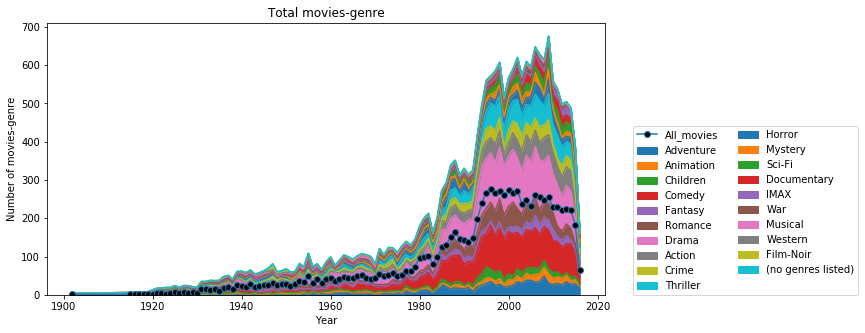

In [21]:
plt.figure(figsize=(10,5))

#Okay, her samler jeg alle items på year
items_grouped = items[['item', 'year']].groupby('year')
df = pd.DataFrame({'All_movies' : items_grouped.item.nunique()})


#Jeg tror det er her der går noget galt ift. items. Vi skal have hvert item og genre ud så vi kan se alle items 
#der er i alle genres
for genre in genres_unique.genre:
    items_grouped = items[items[genre]][['item', 'year']].groupby('year')
    df[genre]=items_grouped.item.nunique()
df.fillna(method='ffill', inplace=True)
df.loc[:,df.columns!='All_movies'].plot.area(stacked=True, figsize=(10,5))


# Plot histogram for all movies
plt.plot(df['All_movies'], marker='o', markerfacecolor='black')
plt.xlabel('Year')
plt.ylabel('Number of movies-genre')
plt.title('Total movies-genre') # Many movies have multiple genres, so counthere is higher than number of movies
plt.legend(loc=(1.05,0), ncol=2)
plt.show()

In [22]:
#Vi kan se her, at den siger at "all movies" kun er 65. løøøøøgn
df.iloc[-1].head()

All_movies    65.0
Adventure     18.0
Animation      7.0
Children       2.0
Comedy        19.0
Name: 2016.0, dtype: float64

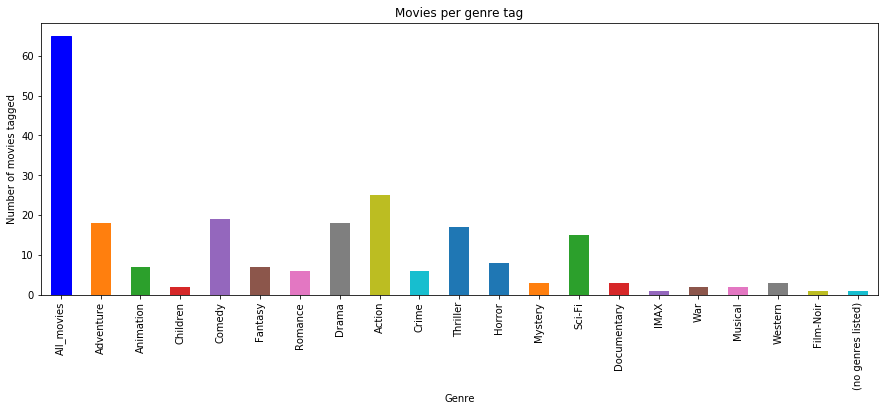

In [23]:
#Det jeg godt kunne tænke mig er en visualisering af distributeringen af alle items inden for hver genre,
#så vi hurtigt kan se, at der er en stor andel af drama film fx



# Plot simple scatter of the number of movies tagged with each genre
plt.figure(figsize=(15,5))
barlist = df.iloc[-1].plot.bar()
barlist.patches[0].set_color('b') # Color 'All_movies' differently, as it's not a genre tag count
plt.xticks(rotation='vertical')
plt.title('Movies per genre tag')
plt.xlabel('Genre')
plt.ylabel('Number of movies tagged')
plt.show()

In [24]:
items['item'].count()

9125

Det jeg tænker her er at se distribueringen af genre OVENPÅ total rating distribtution. 

for helping to identifying consistent ratings or outliers (e.g. Comedies being rated higher in general). We can derive, that all genres show a similar pattern. 

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


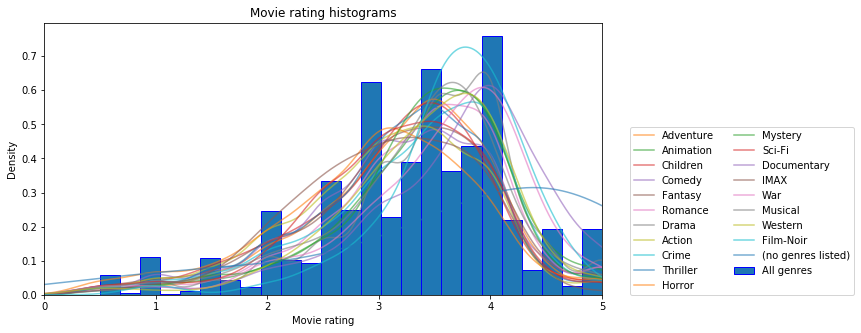

In [25]:
dftmp = ratings[['item','rating']].groupby('item').mean()

# Initialize empty list to capture basic stats by genre
rating_stats = []
# Plot general histogram of all ratings
dftmp.hist(bins=25, grid=False, edgecolor='b', normed=True, label ='All genres', figsize=(10,5))

# Plot histograms per genre
for genre in genres_unique.genre:
    dftmp = items[items[genre]==True]
    dftmp = ratings[ratings.set_index('item').index.isin(dftmp.set_index('item').index)]
    dftmp = dftmp[['item','rating']].groupby('item').mean()
    dftmp.rating.plot(grid=False, alpha=0.6, kind='kde', label=genre) # kde lines er noget til bedre visualisering
    avg = dftmp.rating.mean()
    std = dftmp.rating.std()
    rating_stats.append((genre, avg, std))
plt.legend(loc=(1.05,0), ncol=2)
plt.xlim(0,5)
plt.xlabel('Movie rating')
plt.title('Movie rating histograms')
plt.show()

Try to compute basic statistics (avg and std) for each genre. 

In [26]:
# Construct a DataFrame with all the basic stats per genre
rating_sum = pd.DataFrame(rating_stats,  columns=['genre', 'average', 'std_dev'])
rating_sum.set_index('genre', inplace=True)

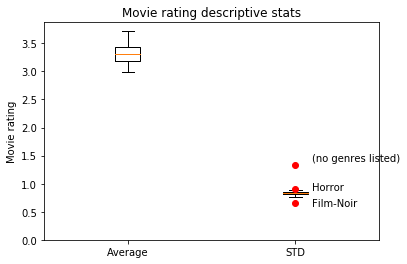

In [27]:
#hehe her er jeg bare gået amok med forskellige måder at visualisere på

#Boxplot with outliers
bxplot = plt.boxplot(rating_sum.T, labels=['Average', 'STD'], sym="ro")

# Properly label the outliers
outliers = []
for i, value in enumerate(bxplot['fliers']):
    for val in value.get_ydata():
        bxplot_label = rating_sum.index[rating_sum.iloc[:, i] == val][0]
        outliers.append(bxplot_label)
        plt.annotate(bxplot_label, xy=(i+1.1, val+np.random.uniform(-0.25,0.25))) # smart trick to prevent overlapping hehe
outliers = set(outliers)
plt.ylim(0,)
plt.ylabel('Movie rating')
plt.title('Movie rating descriptive stats')
plt.show()

In [28]:
# Calculate the normalized number of ratings per genre
rating_sum['num_ratings_norm']=df.iloc[-1, 1:]/df.iloc[-1, 1:].sum()
# Calculate the average rating for all genres
rating_sum['average_all']=rating_sum.average.mean()


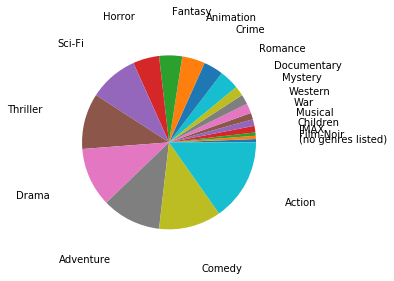

In [29]:
#Pie chart to visualize how 4 genres take almost 50% of ratings being drama, adventure, comedy and action
rating_sum.sort_values(by='num_ratings_norm', inplace=True)
plt.pie(rating_sum['num_ratings_norm'], labels=rating_sum.T.columns, labeldistance=1.5)
plt.show()